Configure notebook...

In [1]:
%load_ext autoreload
%autoreload 2
%pwd

'/work/git/isaac-demo/ipynb'

Imports

In [2]:
from pathlib import Path
import datetime
import pandas as pd
from IPython.display import IFrame, HTML, Markdown, Image, display

Define benchmark

In [3]:
OUT_DIR_BASE = "../out"
BENCH = "embench/crc32"
DATE = "latest"

Lookup directories

In [4]:
BENCH_DIR = Path(OUT_DIR_BASE) / BENCH
print("BENCH_DIR", BENCH_DIR)
assert BENCH_DIR.is_dir()
if DATE == "latest":
    dates = [f for f in BENCH_DIR.iterdir() if f.is_dir()]
    assert len(dates) > 0
    if len(dates) == 1:
        DATE = dates[0].name
    else:
        sorted_dates = sorted(dates, key=lambda x: datetime.datetime.strptime(x.name, "%Y%m%dT%H%M%S"))
        DATE = sorted_dates[-1].name
DATE_DIR = BENCH_DIR / DATE
assert DATE_DIR.is_dir()

print(f"Picked date: {DATE}")
print(f"Directory: {DATE_DIR}")

RUN = DATE_DIR / "run"
SESS = DATE_DIR / "sess"
WORK = DATE_DIR / "work"

PLOTS_DIR = SESS / "plots"

BENCH_DIR ../out/embench/crc32
Picked date: 20250319T155530
Directory: ../out/embench/crc32/20250319T155530


Check baseline benchmark (ISS)

In [5]:
REPORT = RUN / "report.csv"

COLS = ["Model", "Run Instructions", "Total ROM", "Total RAM"]
pd.read_csv(REPORT)[COLS]

,Model,Run Instructions,Total ROM,Total RAM
0,crc32,4005445,44440,2688


## Trace Analysis

### Identification of Bottlenecks

Per basic-block

In [6]:
IFrame(PLOTS_DIR / "runtime_per_llvm_bb.jpg", 700, 350)

Per function

In [7]:
IFrame(PLOTS_DIR / "runtime_per_func.jpg", 700, 350)

Per library

In [8]:
IFrame(PLOTS_DIR / "runtime_per_library.jpg", 700, 350)

Per object

In [9]:
IFrame(PLOTS_DIR / "runtime_per_object.jpg", 700, 350)

### Analyze instruction types

Per major opcode

In [10]:
IFrame(PLOTS_DIR / "runtime_per_opcode.jpg", 700, 350)

Per instruction name

In [11]:
IFrame(PLOTS_DIR / "runtime_per_instr.jpg", 700, 350)

### Choose BBs for ISE identification

In [12]:
CHOICES = SESS / "table" / "choices.pkl"

choices_df = pd.read_pickle(CHOICES)
choices_df

,func_name,file,bb_name,rel_weight,num_instrs,freq
0,rand_beebs,/work/git/isaac-demo/install/mlonmcu/deps/src/...,%bb.0,0.564996,13,174080.0
1,benchmark_body,/work/git/isaac-demo/install/mlonmcu/deps/src/...,%bb.3,0.434612,10,174080.0


In [13]:
num_choices = len(choices_df)
choices_sum_weights = choices_df["rel_weight"].sum()
max_num_instrs = choices_df["num_instrs"].max()
num_choices, choices_sum_weights, max_num_instrs

(2, 0.999608529268429, 13)

## Identification of ISE candidates

### Per Func+BB

Filtered candidates

,Label,Count
0,Iso,127
1,Filtered (Mem),21
2,Selected,19
3,Filtered (Operands),8
4,Filtered (I/O),4


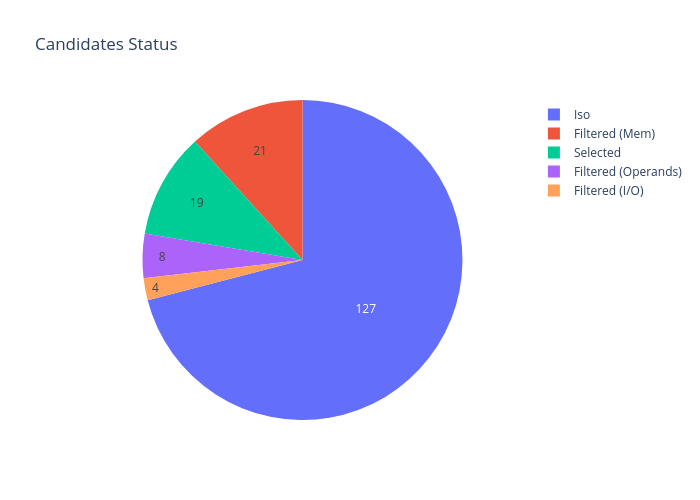

,Label,Count
0,Iso,45
1,Filtered (Mem),14
2,Selected,7
3,Filtered (Operands),1


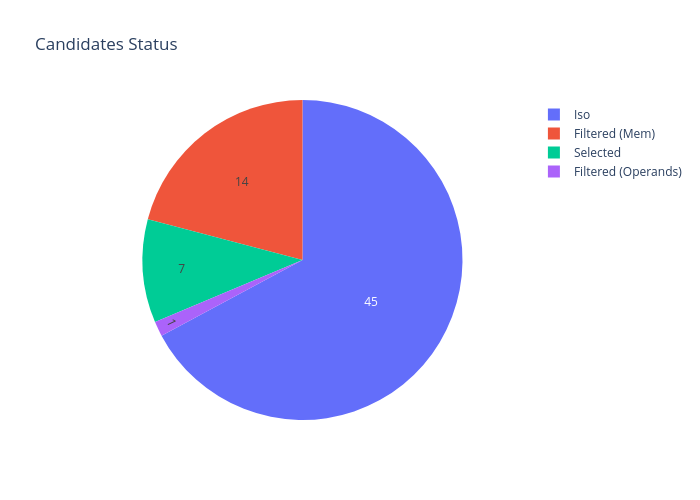

In [14]:
for _, row_data in choices_df.iterrows():
    func_name = row_data["func_name"]
    bb_name = row_data["bb_name"]
    func_bb_dir = WORK / f"{func_name}_{bb_name}_0"  # TODO: chekc suffix?
    pie_csv = func_bb_dir / "pie.csv"
    pie_img = func_bb_dir / "pie.png"
    display(HTML(f"<h2>Func: {func_name}, BB: {bb_name}</h2>"))
    display(pd.read_csv(pie_csv))
    display(Image(pie_img))

Generated variations 

,Label,Count
0,Unknown,179


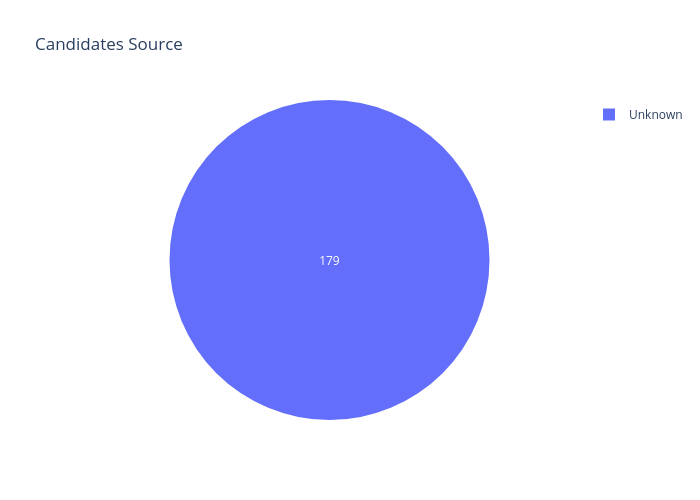

,Label,Count
0,Unknown,67


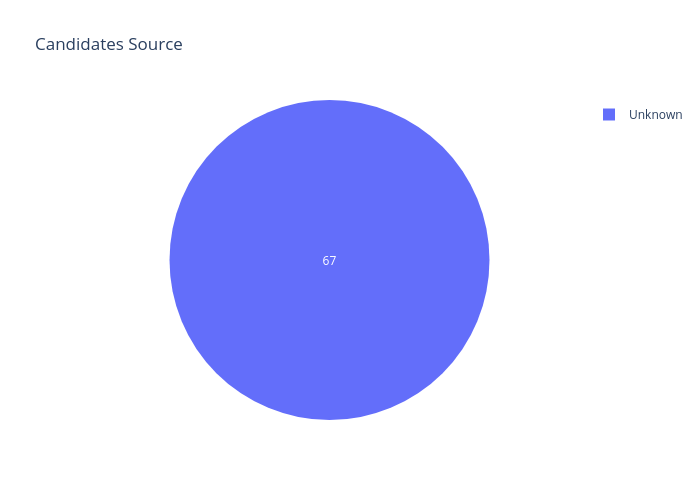

In [15]:
for _, row_data in choices_df.iterrows():
    func_name = row_data["func_name"]
    bb_name = row_data["bb_name"]
    func_bb_dir = WORK / f"{func_name}_{bb_name}_0"  # TODO: check suffix?
    pie2_csv = func_bb_dir / "pie2.csv"
    pie2_img = func_bb_dir / "pie2.png"
    display(HTML(f"<h2>Func: {func_name}, BB: {bb_name}</h2>"))
    display(pd.read_csv(pie2_csv))
    display(Image(pie2_img))

Profile

In [16]:
for _, row_data in choices_df.iterrows():
    func_name = row_data["func_name"]
    bb_name = row_data["bb_name"]
    func_bb_dir = WORK / f"{func_name}_{bb_name}_0"  # TODO: chekc suffix?
    times_csv = func_bb_dir / "times.csv"
    display(HTML(f"<h2>Func: {func_name}, BB: {bb_name}</h2>"))
    display(pd.read_csv(times_csv))

,Name,Secs,Secs (rel.)
0,Settings Validation,0.000062,0.000010
1,Connect to DB,0.000199,0.000033
2,Query func from DB,0.004357,0.000717
3,Query candidates from DB,0.005975,0.000983
4,Conversion to NX (func),0.018046,0.002968
5,Conversion to NX (candidates),0.157738,0.025940
6,Subgraph Generation,0.006646,0.001093
7,Relabeling,0.043871,0.007215
8,Dumping GF graph,0.007672,0.001262
9,I/O Analysis,0.162104,0.026658


,Name,Secs,Secs (rel.)
0,Settings Validation,0.000060,0.000019
1,Connect to DB,0.000191,0.000061
2,Query func from DB,0.004759,0.001525
3,Query candidates from DB,0.008135,0.002606
4,Conversion to NX (func),0.040450,0.012960
5,Conversion to NX (candidates),0.050245,0.016099
6,Subgraph Generation,0.004838,0.001550
7,Relabeling,0.032078,0.010278
8,Dumping GF graph,0.009148,0.002931
9,I/O Analysis,0.059394,0.019030


### Query Metrics

In [17]:
combined_query_metrics_file = WORK / "combined_query_metrics.csv"
pd.read_csv(combined_query_metrics_file)

,num_rows,num_nodes,num_edges,func,basic_block
0,179,9,8,rand_beebs,%bb.0
1,67,9,7,benchmark_body,%bb.3


### Combined results

Pairwise overlaps

In [18]:
overlaps_file = WORK / "overlaps.csv"
pd.read_csv(overlaps_file)

,x,y,nodes,size
0,0,1,set(),0


Venn diagram

In [19]:
venn_file = WORK / "venn.jpg"
if len(choices_df) in [2, 3]:
    if venn_file.is_file():
        display(IFrame(venn_file, 700, 350))

Sankey diagram (duplicates vs. unqiue instructions)

In [20]:
sankey_file =  WORK / "sankey.md"
with open(sankey_file, "r") as f:
    content = f.read()
display(Markdown(content))


```mermaid
---
config:
  sankey:
    showValues: true
---
sankey-beta

%% source,target,value
Set0,Merged,19
Set1,Merged,7
Merged,Duplicates,0
Merged,Unique,26
Unique,Topk,26

```


### Analyse combined index

In [21]:
combined_index_yaml = WORK / "combined_index.yml"
names_csv = WORK / "names.csv"
names_df = pd.read_csv(names_csv)
num_candidates = len(names_df)
names_df

,instr,instr_lower
0,CUSTOM0,custom0
1,CUSTOM1,custom1
2,CUSTOM2,custom2
3,CUSTOM3,custom3
4,CUSTOM4,custom4
5,CUSTOM5,custom5
6,CUSTOM6,custom6
7,CUSTOM7,custom7
8,CUSTOM8,custom8
9,CUSTOM9,custom9


In [22]:
import yaml
with open(combined_index_yaml, "r") as f:
    combined_index_data = yaml.safe_load(f)

In [23]:
temp = combined_index_data["global"]["properties"]
filtered = list(filter(lambda x: x["candidate_count"] > 0, temp))
func_bbs_with_candidates = [(x["func"], x["bb"]) for x in filtered]
func_bbs_with_candidates_weights = [choices_df.where((choices_df["func_name"] == x[0]) & (choices_df["bb_name"] == x[1])).dropna()["rel_weight"].sum() for x in func_bbs_with_candidates]
func_bbs_with_candidates_weights_sum = sum(func_bbs_with_candidates_weights)
len(filtered), func_bbs_with_candidates_weights_sum

(2, 0.999608529268429)

Analyze Encoding Footprint

In [24]:
import sys
sys.path.append("../scripts/")
from analyze_encoding import collect_weights, get_enc_weights_df, plot_enc_pie_multi, get_enc_score_df

In [25]:
enc_size = 32

total_weight, weight_per_instr, footprint_per_instr, rest_weight, bits_per_instr = collect_weights(combined_index_data, enc_size=enc_size)
enc_weights_df = get_enc_weights_df(total_weight, weight_per_instr, bits_per_instr, footprint_per_instr)
# enc_weights_df
enc_score_df = get_enc_score_df(enc_weights_df)
enc_score_df

,instr,bits,footprint,weight,enc_score
0,CUSTOM0,20.0,0.8,0.007812,0.992188
1,CUSTOM1,20.0,0.8,0.007812,0.992188
2,CUSTOM2,20.0,0.8,0.007812,0.992188
3,CUSTOM3,20.0,0.8,0.007812,0.992188
4,CUSTOM4,20.0,0.8,0.007812,0.992188
5,CUSTOM5,15.0,0.6,0.000244,0.999756
6,CUSTOM6,20.0,0.8,0.007812,0.992188
7,CUSTOM7,20.0,0.8,0.007812,0.992188
8,CUSTOM8,20.0,0.8,0.007812,0.992188
9,CUSTOM9,20.0,0.8,0.007812,0.992188


In [26]:
total_weight

0.1042633056640625

Pie chart for enc weights (total and per custom instruction)

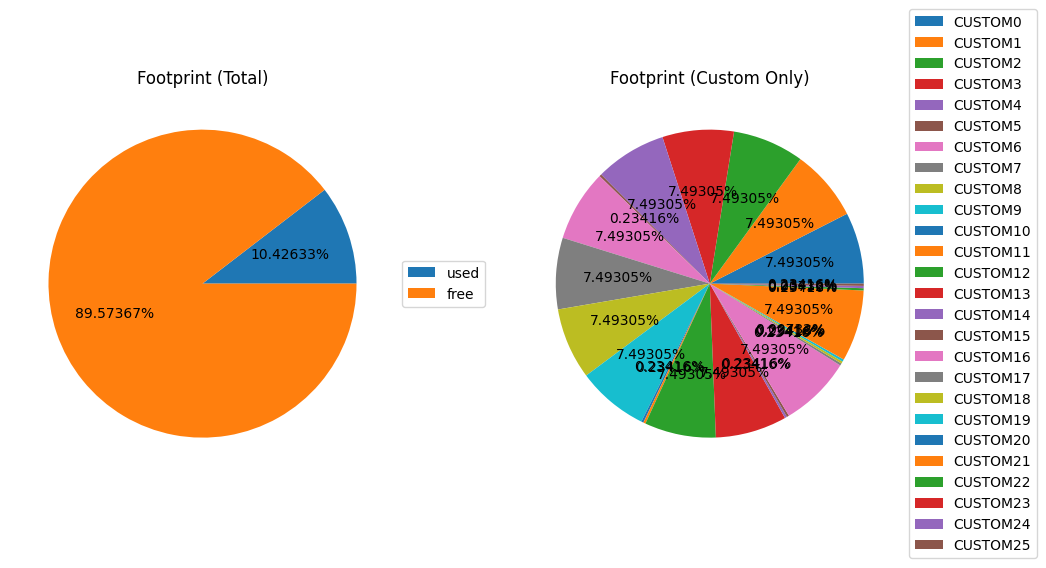

In [27]:
_ = plot_enc_pie_multi(weight_per_instr, rest_weight=rest_weight)

Number of candidates

In [28]:
num_candidates

26

## Analyze Graphs

In [29]:
dot_files = [Path(candidate_data["artifacts"]["io_sub"].replace(".pkl", ".dot")) for candidate_data in combined_index_data["candidates"]]
# dot_files

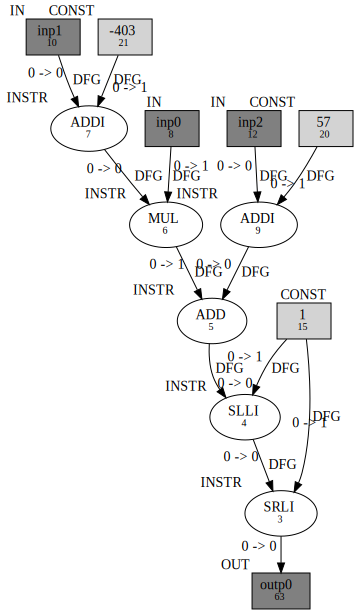

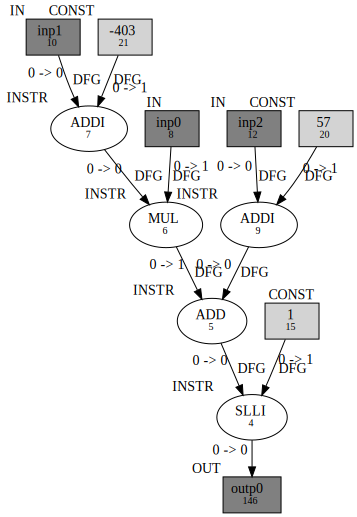

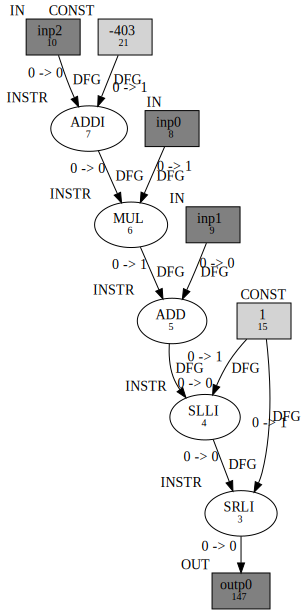

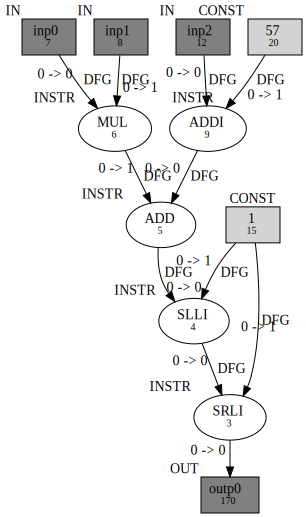

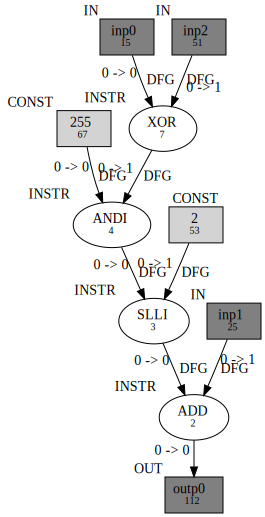

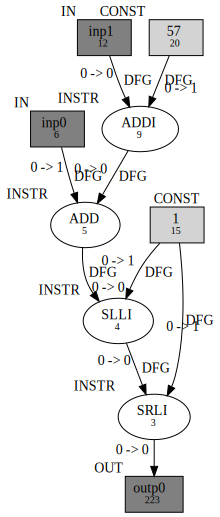

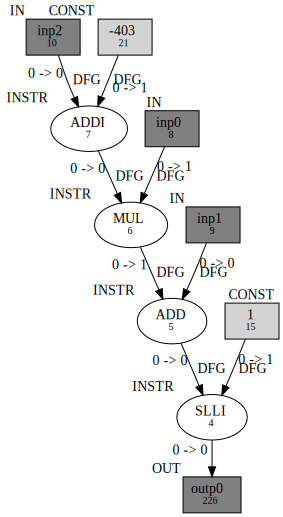

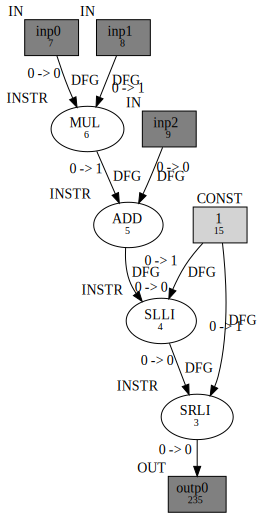

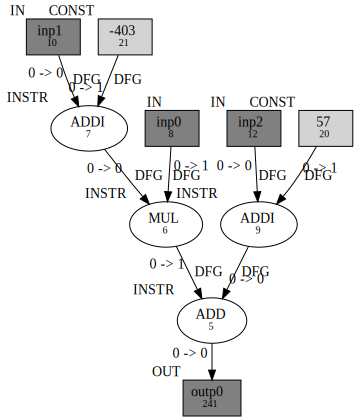

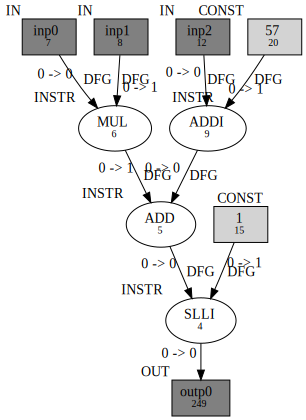

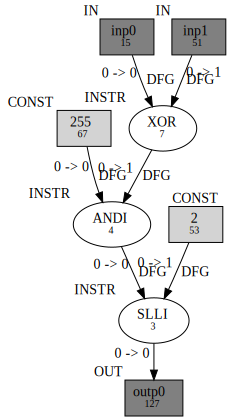

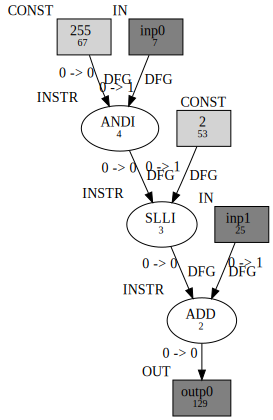

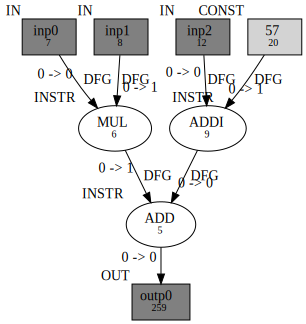

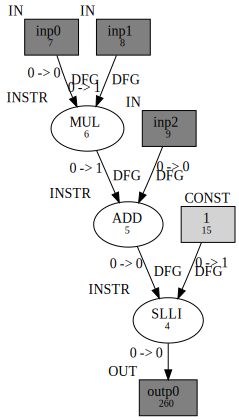

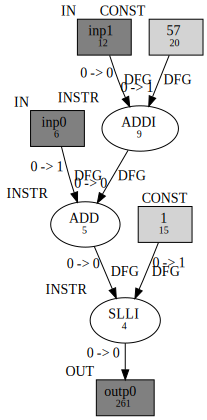

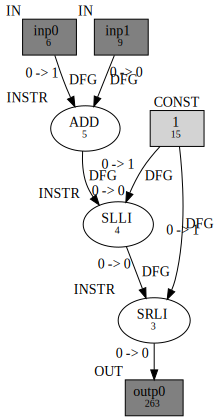

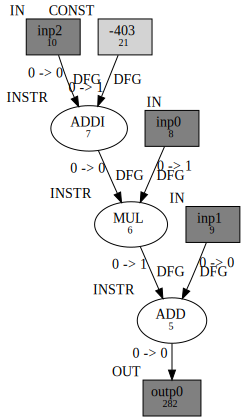

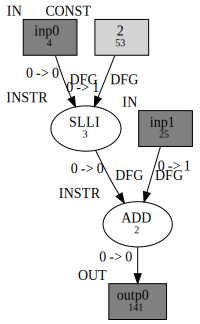

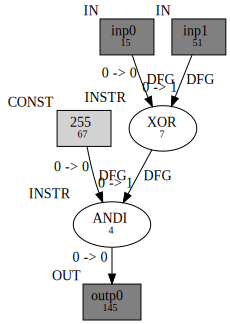

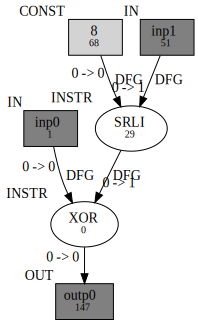

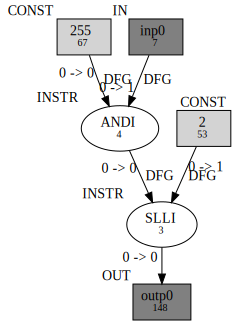

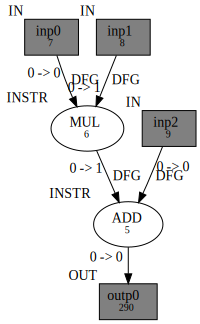

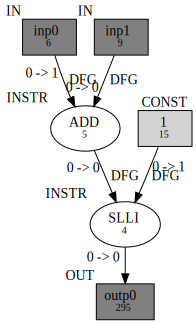

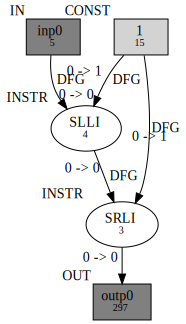

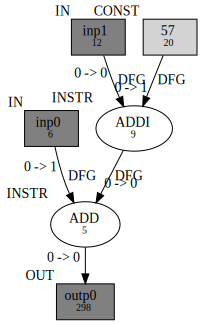

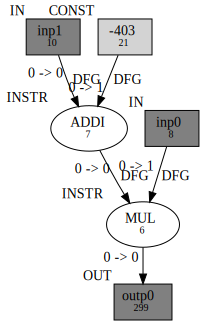

In [30]:
import graphviz

for i, dot_file in enumerate(dot_files):
    display(HTML(f"<h3>ID: {i}, File: {dot_file.name}</h3>"))
    with open(dot_file) as f:
        dot_graph = f.read()
    display(graphviz.Source(dot_graph))

## Generation of Instruction Set

Investigate generated Flat (unfused) CoreDSL per instruction

In [31]:
gen_dir = WORK / "gen"
for file in gen_dir.glob("*.flat"):
    display(HTML(f"<h3>File: {file.name}</h3>"))
    with open(file, "r") as f:
        code = f.read()
    display(Markdown(f"```c\n{code}\n```"""))

```c
// DateTime: 20250320T144321, Sub: 14, Name: name14, Inputs: 2, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(SLLI((unsigned<32>)(ADD((unsigned<32>)(ADDI(rs2_val,(57))),rs1_val)),(1)));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144321, Sub: 15, Name: name15, Inputs: 2, Outputs: 2
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(SRLI((unsigned<32>)(SLLI((unsigned<32>)(ADD(rs2_val,rs1_val)),(1))),(1)));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144328, Sub: 18, Name: name18, Inputs: 2, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(ANDI((255),(unsigned<32>)(XOR(rs1_val,rs2_val))));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144321, Sub: 2, Name: name2, Inputs: 3, Outputs: 2
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs3_val=X[rs3];
unsigned<32> outp0=(unsigned<32>)(SRLI((unsigned<32>)(SLLI((unsigned<32>)(ADD(rs2_val,(unsigned<32>)(MUL((unsigned<32>)(ADDI(rs3_val,(-403))),rs1_val)))),(1))),(1)));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144321, Sub: 8, Name: name8, Inputs: 3, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs3_val=X[rs3];
unsigned<32> outp0=(unsigned<32>)(ADD((unsigned<32>)(ADDI(rs3_val,(57))),(unsigned<32>)(MUL((unsigned<32>)(ADDI(rs2_val,(-403))),rs1_val))));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144321, Sub: 21, Name: name21, Inputs: 3, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs3_val=X[rs3];
unsigned<32> outp0=(unsigned<32>)(ADD(rs3_val,(unsigned<32>)(MUL(rs1_val,rs2_val))));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144328, Sub: 4, Name: name4, Inputs: 3, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs3_val=X[rs3];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(ADD((unsigned<32>)(SLLI((unsigned<32>)(ANDI((255),(unsigned<32>)(XOR(rs1_val,rs3_val)))),(2))),rs2_val));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144321, Sub: 13, Name: name13, Inputs: 3, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs3_val=X[rs3];
unsigned<32> outp0=(unsigned<32>)(SLLI((unsigned<32>)(ADD(rs3_val,(unsigned<32>)(MUL(rs1_val,rs2_val)))),(1)));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144328, Sub: 10, Name: name10, Inputs: 2, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(SLLI((unsigned<32>)(ANDI((255),(unsigned<32>)(XOR(rs1_val,rs2_val)))),(2)));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144321, Sub: 0, Name: name0, Inputs: 3, Outputs: 2
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs3_val=X[rs3];
unsigned<32> outp0=(unsigned<32>)(SRLI((unsigned<32>)(SLLI((unsigned<32>)(ADD((unsigned<32>)(ADDI(rs3_val,(57))),(unsigned<32>)(MUL((unsigned<32>)(ADDI(rs2_val,(-403))),rs1_val)))),(1))),(1)));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144321, Sub: 16, Name: name16, Inputs: 3, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs3_val=X[rs3];
unsigned<32> outp0=(unsigned<32>)(ADD(rs2_val,(unsigned<32>)(MUL((unsigned<32>)(ADDI(rs3_val,(-403))),rs1_val))));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144328, Sub: 19, Name: name19, Inputs: 2, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(XOR(rs1_val,(unsigned<32>)(SRLI((8),rs2_val))));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144328, Sub: 20, Name: name20, Inputs: 1, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(SLLI((unsigned<32>)(ANDI((255),rs1_val)),(2)));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144328, Sub: 17, Name: name17, Inputs: 2, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(ADD((unsigned<32>)(SLLI(rs1_val,(2))),rs2_val));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144321, Sub: 9, Name: name9, Inputs: 3, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs3_val=X[rs3];
unsigned<32> outp0=(unsigned<32>)(SLLI((unsigned<32>)(ADD((unsigned<32>)(ADDI(rs3_val,(57))),(unsigned<32>)(MUL(rs1_val,rs2_val)))),(1)));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144321, Sub: 6, Name: name6, Inputs: 3, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs3_val=X[rs3];
unsigned<32> outp0=(unsigned<32>)(SLLI((unsigned<32>)(ADD(rs2_val,(unsigned<32>)(MUL((unsigned<32>)(ADDI(rs3_val,(-403))),rs1_val)))),(1)));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144321, Sub: 5, Name: name5, Inputs: 2, Outputs: 2
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(SRLI((unsigned<32>)(SLLI((unsigned<32>)(ADD((unsigned<32>)(ADDI(rs2_val,(57))),rs1_val)),(1))),(1)));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144321, Sub: 12, Name: name12, Inputs: 3, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs3_val=X[rs3];
unsigned<32> outp0=(unsigned<32>)(ADD((unsigned<32>)(ADDI(rs3_val,(57))),(unsigned<32>)(MUL(rs1_val,rs2_val))));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144321, Sub: 24, Name: name24, Inputs: 2, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(ADD((unsigned<32>)(ADDI(rs2_val,(57))),rs1_val));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144321, Sub: 23, Name: name23, Inputs: 1, Outputs: 2
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(SRLI((unsigned<32>)(SLLI(rs1_val,(1))),(1)));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144321, Sub: 3, Name: name3, Inputs: 3, Outputs: 2
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs3_val=X[rs3];
unsigned<32> outp0=(unsigned<32>)(SRLI((unsigned<32>)(SLLI((unsigned<32>)(ADD((unsigned<32>)(ADDI(rs3_val,(57))),(unsigned<32>)(MUL(rs1_val,rs2_val)))),(1))),(1)));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144321, Sub: 25, Name: name25, Inputs: 2, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(MUL((unsigned<32>)(ADDI(rs2_val,(-403))),rs1_val));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144321, Sub: 1, Name: name1, Inputs: 3, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs3_val=X[rs3];
unsigned<32> outp0=(unsigned<32>)(SLLI((unsigned<32>)(ADD((unsigned<32>)(ADDI(rs3_val,(57))),(unsigned<32>)(MUL((unsigned<32>)(ADDI(rs2_val,(-403))),rs1_val)))),(1)));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144321, Sub: 7, Name: name7, Inputs: 3, Outputs: 2
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs3_val=X[rs3];
unsigned<32> outp0=(unsigned<32>)(SRLI((unsigned<32>)(SLLI((unsigned<32>)(ADD(rs3_val,(unsigned<32>)(MUL(rs1_val,rs2_val)))),(1))),(1)));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144321, Sub: 22, Name: name22, Inputs: 2, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(SLLI((unsigned<32>)(ADD(rs2_val,rs1_val)),(1)));
X[rd]=outp0;
```

```c
// DateTime: 20250320T144328, Sub: 11, Name: name11, Inputs: 2, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> rs2_val=X[rs2];
unsigned<32> outp0=(unsigned<32>)(ADD((unsigned<32>)(SLLI((unsigned<32>)(ANDI((255),rs1_val)),(2))),rs2_val));
X[rd]=outp0;
```

CoreDSL Set with automatic encoding

In [32]:
set_file = WORK / "XIsaac.core_desc"

with open(set_file, "r") as f:
    code = f.read()

display(Markdown(f"```c\n{code}\n```"""))

```c
import "/work/git/isaac-demo/etiss_arch_riscv/rv_base/RVI.core_desc"

InstructionSet XIsaac extends RV32I {
    instructions {
        CUSTOM0 {
            encoding: 2'b00 :: rs3[4:0] :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom0", "{name(rd)}, {name(rs1)}, {name(rs2)}, {name(rs3)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs3_val = X[rs3];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)((unsigned<32>)((((unsigned<32>)((unsigned<32>)((((signed<32>)((unsigned<32>)((((signed<32>)(rs3_val) + (signed<32>)((57)))))) + (signed<32>)((unsigned<32>)((((signed<32>)((unsigned<32>)((((signed<32>)(rs2_val) + (signed<32>)((-403)))))) * (signed<32>)(rs1_val))))))))) << (unsigned<32>)((1)))))) >> (unsigned<32>)((1)))));
                X[rd] = outp0;
            }
        }
        CUSTOM1 {
            encoding: 2'b01 :: rs3[4:0] :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom1", "{name(rd)}, {name(rs1)}, {name(rs2)}, {name(rs3)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs3_val = X[rs3];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)((unsigned<32>)((((signed<32>)((unsigned<32>)((((signed<32>)(rs3_val) + (signed<32>)((57)))))) + (signed<32>)((unsigned<32>)((((signed<32>)((unsigned<32>)((((signed<32>)(rs2_val) + (signed<32>)((-403)))))) * (signed<32>)(rs1_val))))))))) << (unsigned<32>)((1)))));
                X[rd] = outp0;
            }
        }
        CUSTOM2 {
            encoding: 2'b10 :: rs3[4:0] :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom2", "{name(rd)}, {name(rs1)}, {name(rs2)}, {name(rs3)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs3_val = X[rs3];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)((unsigned<32>)((((unsigned<32>)((unsigned<32>)((((signed<32>)(rs2_val) + (signed<32>)((unsigned<32>)((((signed<32>)((unsigned<32>)((((signed<32>)(rs3_val) + (signed<32>)((-403)))))) * (signed<32>)(rs1_val))))))))) << (unsigned<32>)((1)))))) >> (unsigned<32>)((1)))));
                X[rd] = outp0;
            }
        }
        CUSTOM3 {
            encoding: 2'b11 :: rs3[4:0] :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom3", "{name(rd)}, {name(rs1)}, {name(rs2)}, {name(rs3)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs3_val = X[rs3];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)((unsigned<32>)((((unsigned<32>)((unsigned<32>)((((signed<32>)((unsigned<32>)((((signed<32>)(rs3_val) + (signed<32>)((57)))))) + (signed<32>)((unsigned<32>)((((signed<32>)(rs1_val) * (signed<32>)(rs2_val))))))))) << (unsigned<32>)((1)))))) >> (unsigned<32>)((1)))));
                X[rd] = outp0;
            }
        }
        CUSTOM4 {
            encoding: 2'b00 :: rs3[4:0] :: rs2[4:0] :: rs1[4:0] :: 3'b001 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom4", "{name(rd)}, {name(rs1)}, {name(rs2)}, {name(rs3)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs3_val = X[rs3];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)((unsigned<32>)((((unsigned<32>)((unsigned<32>)((((unsigned<32>)((255)) & (unsigned<32>)((unsigned<32>)((((unsigned<32>)(rs1_val) ^ (unsigned<32>)(rs3_val))))))))) << (unsigned<32>)((2)))))) + (signed<32>)(rs2_val))));
                X[rd] = outp0;
            }
        }
        CUSTOM5 {
            encoding: 7'b0000000 :: rs2[4:0] :: rs1[4:0] :: 3'b010 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom5", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)((unsigned<32>)((((unsigned<32>)((unsigned<32>)((((signed<32>)((unsigned<32>)((((signed<32>)(rs2_val) + (signed<32>)((57)))))) + (signed<32>)(rs1_val))))) << (unsigned<32>)((1)))))) >> (unsigned<32>)((1)))));
                X[rd] = outp0;
            }
        }
        CUSTOM6 {
            encoding: 2'b01 :: rs3[4:0] :: rs2[4:0] :: rs1[4:0] :: 3'b001 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom6", "{name(rd)}, {name(rs1)}, {name(rs2)}, {name(rs3)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs3_val = X[rs3];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)((unsigned<32>)((((signed<32>)(rs2_val) + (signed<32>)((unsigned<32>)((((signed<32>)((unsigned<32>)((((signed<32>)(rs3_val) + (signed<32>)((-403)))))) * (signed<32>)(rs1_val))))))))) << (unsigned<32>)((1)))));
                X[rd] = outp0;
            }
        }
        CUSTOM7 {
            encoding: 2'b10 :: rs3[4:0] :: rs2[4:0] :: rs1[4:0] :: 3'b001 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom7", "{name(rd)}, {name(rs1)}, {name(rs2)}, {name(rs3)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs3_val = X[rs3];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)((unsigned<32>)((((unsigned<32>)((unsigned<32>)((((signed<32>)(rs3_val) + (signed<32>)((unsigned<32>)((((signed<32>)(rs1_val) * (signed<32>)(rs2_val))))))))) << (unsigned<32>)((1)))))) >> (unsigned<32>)((1)))));
                X[rd] = outp0;
            }
        }
        CUSTOM8 {
            encoding: 2'b11 :: rs3[4:0] :: rs2[4:0] :: rs1[4:0] :: 3'b001 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom8", "{name(rd)}, {name(rs1)}, {name(rs2)}, {name(rs3)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs3_val = X[rs3];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)((unsigned<32>)((((signed<32>)(rs3_val) + (signed<32>)((57)))))) + (signed<32>)((unsigned<32>)((((signed<32>)((unsigned<32>)((((signed<32>)(rs2_val) + (signed<32>)((-403)))))) * (signed<32>)(rs1_val))))))));
                X[rd] = outp0;
            }
        }
        CUSTOM9 {
            encoding: 2'b00 :: rs3[4:0] :: rs2[4:0] :: rs1[4:0] :: 3'b011 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom9", "{name(rd)}, {name(rs1)}, {name(rs2)}, {name(rs3)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs3_val = X[rs3];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)((unsigned<32>)((((signed<32>)((unsigned<32>)((((signed<32>)(rs3_val) + (signed<32>)((57)))))) + (signed<32>)((unsigned<32>)((((signed<32>)(rs1_val) * (signed<32>)(rs2_val))))))))) << (unsigned<32>)((1)))));
                X[rd] = outp0;
            }
        }
        CUSTOM10 {
            encoding: 7'b0000001 :: rs2[4:0] :: rs1[4:0] :: 3'b010 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom10", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)((unsigned<32>)((((unsigned<32>)((255)) & (unsigned<32>)((unsigned<32>)((((unsigned<32>)(rs1_val) ^ (unsigned<32>)(rs2_val))))))))) << (unsigned<32>)((2)))));
                X[rd] = outp0;
            }
        }
        CUSTOM11 {
            encoding: 7'b0000010 :: rs2[4:0] :: rs1[4:0] :: 3'b010 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom11", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)((unsigned<32>)((((unsigned<32>)((unsigned<32>)((((unsigned<32>)((255)) & (unsigned<32>)(rs1_val))))) << (unsigned<32>)((2)))))) + (signed<32>)(rs2_val))));
                X[rd] = outp0;
            }
        }
        CUSTOM12 {
            encoding: 2'b01 :: rs3[4:0] :: rs2[4:0] :: rs1[4:0] :: 3'b011 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom12", "{name(rd)}, {name(rs1)}, {name(rs2)}, {name(rs3)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs3_val = X[rs3];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)((unsigned<32>)((((signed<32>)(rs3_val) + (signed<32>)((57)))))) + (signed<32>)((unsigned<32>)((((signed<32>)(rs1_val) * (signed<32>)(rs2_val))))))));
                X[rd] = outp0;
            }
        }
        CUSTOM13 {
            encoding: 2'b10 :: rs3[4:0] :: rs2[4:0] :: rs1[4:0] :: 3'b011 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom13", "{name(rd)}, {name(rs1)}, {name(rs2)}, {name(rs3)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs3_val = X[rs3];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)((unsigned<32>)((((signed<32>)(rs3_val) + (signed<32>)((unsigned<32>)((((signed<32>)(rs1_val) * (signed<32>)(rs2_val))))))))) << (unsigned<32>)((1)))));
                X[rd] = outp0;
            }
        }
        CUSTOM14 {
            encoding: 7'b0000011 :: rs2[4:0] :: rs1[4:0] :: 3'b010 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom14", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)((unsigned<32>)((((signed<32>)((unsigned<32>)((((signed<32>)(rs2_val) + (signed<32>)((57)))))) + (signed<32>)(rs1_val))))) << (unsigned<32>)((1)))));
                X[rd] = outp0;
            }
        }
        CUSTOM15 {
            encoding: 7'b0000100 :: rs2[4:0] :: rs1[4:0] :: 3'b010 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom15", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)((unsigned<32>)((((unsigned<32>)((unsigned<32>)((((signed<32>)(rs2_val) + (signed<32>)(rs1_val))))) << (unsigned<32>)((1)))))) >> (unsigned<32>)((1)))));
                X[rd] = outp0;
            }
        }
        CUSTOM16 {
            encoding: 2'b11 :: rs3[4:0] :: rs2[4:0] :: rs1[4:0] :: 3'b011 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom16", "{name(rd)}, {name(rs1)}, {name(rs2)}, {name(rs3)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs3_val = X[rs3];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)(rs2_val) + (signed<32>)((unsigned<32>)((((signed<32>)((unsigned<32>)((((signed<32>)(rs3_val) + (signed<32>)((-403)))))) * (signed<32>)(rs1_val))))))));
                X[rd] = outp0;
            }
        }
        CUSTOM17 {
            encoding: 7'b0000101 :: rs2[4:0] :: rs1[4:0] :: 3'b010 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom17", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)((unsigned<32>)((((unsigned<32>)(rs1_val) << (unsigned<32>)((2)))))) + (signed<32>)(rs2_val))));
                X[rd] = outp0;
            }
        }
        CUSTOM18 {
            encoding: 7'b0000110 :: rs2[4:0] :: rs1[4:0] :: 3'b010 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom18", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)((255)) & (unsigned<32>)((unsigned<32>)((((unsigned<32>)(rs1_val) ^ (unsigned<32>)(rs2_val))))))));
                X[rd] = outp0;
            }
        }
        CUSTOM19 {
            encoding: 7'b0000111 :: rs2[4:0] :: rs1[4:0] :: 3'b010 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom19", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)(rs1_val) ^ (unsigned<32>)((unsigned<32>)((((unsigned<32>)((8)) >> (unsigned<32>)(rs2_val))))))));
                X[rd] = outp0;
            }
        }
        CUSTOM20 {
            encoding: 7'b0001000 :: 5'b00000 :: rs1[4:0] :: 3'b010 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom20", "{name(rd)}, {name(rs1)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)((unsigned<32>)((((unsigned<32>)((255)) & (unsigned<32>)(rs1_val))))) << (unsigned<32>)((2)))));
                X[rd] = outp0;
            }
        }
        CUSTOM21 {
            encoding: 2'b00 :: rs3[4:0] :: rs2[4:0] :: rs1[4:0] :: 3'b100 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom21", "{name(rd)}, {name(rs1)}, {name(rs2)}, {name(rs3)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs3_val = X[rs3];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)(rs3_val) + (signed<32>)((unsigned<32>)((((signed<32>)(rs1_val) * (signed<32>)(rs2_val))))))));
                X[rd] = outp0;
            }
        }
        CUSTOM22 {
            encoding: 7'b0001001 :: rs2[4:0] :: rs1[4:0] :: 3'b010 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom22", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)((unsigned<32>)((((signed<32>)(rs2_val) + (signed<32>)(rs1_val))))) << (unsigned<32>)((1)))));
                X[rd] = outp0;
            }
        }
        CUSTOM23 {
            encoding: 7'b0001010 :: 5'b00000 :: rs1[4:0] :: 3'b010 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom23", "{name(rd)}, {name(rs1)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> outp0 = (unsigned<32>)((((unsigned<32>)((unsigned<32>)((((unsigned<32>)(rs1_val) << (unsigned<32>)((1)))))) >> (unsigned<32>)((1)))));
                X[rd] = outp0;
            }
        }
        CUSTOM24 {
            encoding: 7'b0001011 :: rs2[4:0] :: rs1[4:0] :: 3'b010 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom24", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)((unsigned<32>)((((signed<32>)(rs2_val) + (signed<32>)((57)))))) + (signed<32>)(rs1_val))));
                X[rd] = outp0;
            }
        }
        CUSTOM25 {
            encoding: 7'b0001100 :: rs2[4:0] :: rs1[4:0] :: 3'b010 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom25", "{name(rd)}, {name(rs1)}, {name(rs2)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)((unsigned<32>)((((signed<32>)(rs2_val) + (signed<32>)((-403)))))) * (signed<32>)(rs1_val))));
                X[rd] = outp0;
            }
        }
    }
}


```

## LLVM Retargeting

## Seal5 Reports

In [33]:
reports_dir = WORK / "docker" / "seal5_reports"

### Properties

In [34]:
properties_csv = reports_dir / "properties.csv"
pd.read_csv(properties_csv)

,model,set,xlen,is_rv32,is_rv64,instr,enc_size,is_compressed,enc_format,opcode,...,is_simo,has_imm_leaf,has_side_effects,may_load,may_store,is_terminator,is_branch,skip_pattern_gen,uses_custom_reg,defs_custom_reg
0,XIsaac,XIsaac,32,True,False,CUSTOM0,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
1,XIsaac,XIsaac,32,True,False,CUSTOM1,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
2,XIsaac,XIsaac,32,True,False,CUSTOM2,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
3,XIsaac,XIsaac,32,True,False,CUSTOM3,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
4,XIsaac,XIsaac,32,True,False,CUSTOM4,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
5,XIsaac,XIsaac,32,True,False,CUSTOM5,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
6,XIsaac,XIsaac,32,True,False,CUSTOM6,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
7,XIsaac,XIsaac,32,True,False,CUSTOM7,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
8,XIsaac,XIsaac,32,True,False,CUSTOM8,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
9,XIsaac,XIsaac,32,True,False,CUSTOM9,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False


### Stage Times

In [35]:
stage_times_csv = reports_dir / "stage_times.csv"
pd.read_csv(stage_times_csv)[["stage", "time_s"]].dropna()

,stage,time_s
0,setup,38.539287
1,patch,19.154846
2,build,856.552231
3,transform,1.658140
4,generate,1.602588
5,patch,11.450410
6,build,61.829908
7,build,7.468186
8,build,7.540792
9,generate,3.560736


### Passes

In [36]:
seal5_status_csv = reports_dir / "status.csv"
seal5_status_compact_csv = reports_dir / "status_compact.csv"
seal5_status_df = pd.read_csv(seal5_status_csv)
seal5_status_compact_df = pd.read_csv(seal5_status_compact_csv)
seal5_status_compact_df

,model,set,xlen,instr,n_success,n_skipped,n_failed,n_total,status
0,XIsaac,XIsaac,32,CUSTOM0,13,0,1,14,bad
1,XIsaac,XIsaac,32,CUSTOM1,14,0,0,14,good
2,XIsaac,XIsaac,32,CUSTOM2,13,0,1,14,bad
3,XIsaac,XIsaac,32,CUSTOM3,14,0,0,14,good
4,XIsaac,XIsaac,32,CUSTOM4,14,0,0,14,good
5,XIsaac,XIsaac,32,CUSTOM5,14,0,0,14,good
6,XIsaac,XIsaac,32,CUSTOM6,14,0,0,14,good
7,XIsaac,XIsaac,32,CUSTOM7,14,0,0,14,good
8,XIsaac,XIsaac,32,CUSTOM8,14,0,0,14,good
9,XIsaac,XIsaac,32,CUSTOM9,14,0,0,14,good


### Test Results/Coverage

In [37]:
# test_coverage_compact_csv = reports_dir / "test_coverage_compact.csv"
# pd.read_csv(test_coverage_compact_csv)

In [38]:
# test_results_compact_csv = reports_dir / "test_results_compact.csv"
# pd.read_csv(test_results_compact_csv)

### Changed Files/Lines

In [39]:
seal5_diff_csv = reports_dir / "diff.csv"
seal5_diff_df = pd.read_csv(seal5_diff_csv)
seal5_diff_df

,phase,n_files_changed,n_insertions,n_deletions
0,PHASE_0,32,4609,5
1,PHASE_1,3,15,0
2,PHASE_2,28,1183,0
3,PHASE_3,0,0,0
4,PHASE_4,25,264,0
5,PHASE_5,0,0,0
6,*,84,6071,5


In [40]:
seal5_diff_csv

PosixPath('../out/embench/crc32/20250319T155530/work/docker/seal5_reports/diff.csv')

### Seal5 Score

In [41]:
seal5_score_data = []
seal5_pattern_gen_status_df = seal5_status_df[seal5_status_df["pass"] == "generate_passes.pattern_gen.behav_to_pat"][["instr", "status"]]
seal5_passes_status_df = seal5_status_compact_df[["instr", "status"]]
# print("seal5_passes_status_df", seal5_passes_status_df)
for instr_name in seal5_status_df["instr"].unique():
    # print("instr_name", instr_name)
    passes_status = seal5_passes_status_df[seal5_passes_status_df["instr"] == instr_name]
    assert len(passes_status) == 1
    passes_status = passes_status["status"].iloc[0]
    passes_score = 1.0 if passes_status == "good" else (0.5 if passes_status == "ok" else 0.0)
    
    pattern_gen_status = seal5_pattern_gen_status_df[seal5_pattern_gen_status_df["instr"] == instr_name]
    assert len(pattern_gen_status) == 1
    pattern_gen_status = pattern_gen_status["status"].iloc[0]
    # print("pattern_gen_status", pattern_gen_status)
    pattern_gen_score = 1.0 if pattern_gen_status == "success" else -1.0
    # print("pattern_gen_score", pattern_gen_score)
    
    new = {"instr": instr_name, "pattern_gen_score": pattern_gen_score, "passes_score": passes_score}
    seal5_score_data.append(new)
    
def calc_seal5_score(x):
    return x.min()

seal5_score_df = pd.DataFrame(seal5_score_data)
seal5_score_df["seal5_score"] =  seal5_score_df[["pattern_gen_score", "passes_score"]].apply(calc_seal5_score, axis=1)
seal5_score_df
# TODO: write to file

,instr,pattern_gen_score,passes_score,seal5_score
0,CUSTOM0,-1.0,0.0,-1.0
1,CUSTOM1,1.0,1.0,1.0
2,CUSTOM2,-1.0,0.0,-1.0
3,CUSTOM3,1.0,1.0,1.0
4,CUSTOM4,1.0,1.0,1.0
5,CUSTOM5,1.0,1.0,1.0
6,CUSTOM6,1.0,1.0,1.0
7,CUSTOM7,1.0,1.0,1.0
8,CUSTOM8,1.0,1.0,1.0
9,CUSTOM9,1.0,1.0,1.0


## ISS Evaluation

In [42]:
RUN_COMPARE = Path(str(RUN) + "_compare")
REPORT_COMPARE = RUN_COMPARE / "report.csv"

COLS = ["Model", "Arch", "Run Instructions", "Run Instructions (rel.)"]
bench_compare_df = pd.read_csv(REPORT_COMPARE)[COLS]
bench_compare_df

,Model,Arch,Run Instructions,Run Instructions (rel.)
0,crc32,rv32imfd,4005445,1.000000
1,crc32,rv32imfd_xisaac,3135045,0.782696


In [43]:
#TEMP
RUN_COMPARE = Path(str(RUN) + "_compare")
REPORT_COMPARE = RUN_COMPARE / "report.csv"

COLS = ["Model", "Arch", "Run Instructions", "Run Instructions (rel.)"]
bench_compare_df = pd.read_csv(REPORT_COMPARE)[COLS]
bench_compare_df

,Model,Arch,Run Instructions,Run Instructions (rel.)
0,crc32,rv32imfd,4005445,1.000000
1,crc32,rv32imfd_xisaac,3135045,0.782696


In [44]:
RUN_COMPARE_MEM = Path(str(RUN) + "_compare_mem")
REPORT_COMPARE_MEM = RUN_COMPARE_MEM / "report.csv"

COLS = ["Model", "Arch", "Total ROM", "Total RAM", "ROM code", "ROM code (rel.)"]
bench_compare_mem_df = pd.read_csv(REPORT_COMPARE_MEM)[COLS]
bench_compare_mem_df

,Model,Arch,Total ROM,Total RAM,ROM code,ROM code (rel.)
0,crc32,rv32imfd,3720,1216,2620,1.000000
1,crc32,rv32imfd_xisaac,3700,1216,2600,0.992366


In [45]:
# temp
RUN_COMPARE_MEM = Path(str(RUN) + "_compare_mem")
REPORT_COMPARE_MEM = RUN_COMPARE_MEM / "report.csv"

COLS = ["Model", "Arch", "Total ROM", "Total RAM", "ROM code", "ROM code (rel.)"]
bench_compare_mem_df = pd.read_csv(REPORT_COMPARE_MEM)[COLS]
bench_compare_mem_df

,Model,Arch,Total ROM,Total RAM,ROM code,ROM code (rel.)
0,crc32,rv32imfd,3720,1216,2620,1.000000
1,crc32,rv32imfd_xisaac,3700,1216,2600,0.992366


### MLonMCU Score (Set)

In [46]:
assert len(bench_compare_df) == 2
run_instrs_rel = bench_compare_df["Run Instructions (rel.)"].iloc[-1]
assert len(bench_compare_mem_df) == 2
rom_code_rel = bench_compare_mem_df["ROM code (rel.)"].iloc[-1]

run_instrs_score = 1.0/run_instrs_rel-1
rom_code_score = 1.0/rom_code_rel-1

# TODO: cycles!

RUN_INSTR_WEIGHT_POS = 2
ROM_CODE_WEIGHT_POS = 1
RUN_INSTR_WEIGTH_NEG = 10
ROM_CODE_WEIGHT_NEG = 2

mlonmcu_set_score_data = [{"set": "XIsaac", "run_instrs_score": run_instrs_score, "rom_code_score": rom_code_score}]

def calc_mlonmcu_score(x):
    # return gmean([x["run_instrs_score"], x["rom_code_score"]], weights=[RUN_INSTR_WEIGHT, ROM_CODE_WEIGHT])
    a = x["run_instrs_score"]
    a = a * RUN_INSTR_WEIGHT_POS if a > 0 else a * RUN_INSTR_WEIGTH_NEG
    print(a)
    b = x["rom_code_score"]
    b = b * ROM_CODE_WEIGHT_POS if b > 0 else b * ROM_CODE_WEIGHT_NEG
    print(b)
    temp = a + b
    return max(-1.0, min(1.0, temp))

mlonmcu_set_score_df = pd.DataFrame(mlonmcu_set_score_data)
mlonmcu_set_score_df["mlonmcu_score"] =  mlonmcu_set_score_df[["run_instrs_score", "rom_code_score"]].apply(calc_mlonmcu_score, axis=1)
mlonmcu_set_score_df
# TODO: write to file

0.5552711364589662
0.007692307692307665


,set,run_instrs_score,rom_code_score,mlonmcu_score
0,XIsaac,0.277636,0.007692,0.562963


## Dynamic Analysis

In [47]:
SESS_NEW = DATE_DIR / "sess_new"
PLOTS_DIR_NEW = SESS_NEW / "plots"

In [48]:
IFrame(PLOTS_DIR_NEW / "runtime_per_llvm_bb.jpg", 700, 350)

In [49]:
IFrame(PLOTS_DIR_NEW / "runtime_per_func.jpg", 700, 350)

In [50]:
IFrame(PLOTS_DIR_NEW / "runtime_per_opcode.jpg", 700, 350)

In [51]:
IFrame(PLOTS_DIR_NEW / "runtime_per_instr.jpg", 700, 350)

In [52]:
opcodes_hist_file = SESS_NEW / "table" / "opcodes_hist.pkl"
opcodes_hist_df = pd.read_pickle(opcodes_hist_file)
print("All opcodes:")
display(opcodes_hist_df)
print("Custom only:")
display(opcodes_hist_df[opcodes_hist_df["opcode"].apply(lambda x: "custom" in x)])

All opcodes:


,opcode,count,rel_count
0,OP-IMM,872257,0.276979
1,LUI,522617,0.165953
2,custom-3/rv128,522243,0.165835
3,LOAD,349185,0.110881
4,BRANCH,175915,0.055861
5,OP,175130,0.055611
6,STORE,174963,0.055558
7,JAL,174492,0.055409
8,JALR,174284,0.055343
9,OP-IMM (Compressed),2114,0.000671


Custom only:


,opcode,count,rel_count
2,custom-3/rv128,522243,0.165835


In [53]:
instrs_hist_file = SESS_NEW / "table" / "instrs_hist.pkl"
instrs_hist_df = pd.read_pickle(instrs_hist_file)
print("All instructions:")
display(instrs_hist_df)
print("Custom only:")
custom_instrs_hist_df = instrs_hist_df[instrs_hist_df["instr"].apply(lambda x: "custom" in x)]
display(custom_instrs_hist_df)

All instructions:


,instr,count,rel_count
0,addi,523490,1.662306e-01
1,lui,522617,1.659534e-01
2,lw,348566,1.106847e-01
3,srli,348164,1.105570e-01
4,bne,174666,5.546396e-02
...,...,...,...
62,csrai,6,1.905258e-06
63,or,4,1.270172e-06
64,sltiu,3,9.526289e-07
65,sll,2,6.350860e-07


Custom only:


,instr,count,rel_count
8,custom17,174083,0.055279
10,custom7,174080,0.055278
11,custom18,174080,0.055278


In [54]:
# temp
instrs_hist_file = SESS_NEW / "table" / "instrs_hist.pkl"
instrs_hist_df = pd.read_pickle(instrs_hist_file)
print("All instructions:")
display(instrs_hist_df)
print("Custom only:")
custom_instrs_hist_df = instrs_hist_df[instrs_hist_df["instr"].apply(lambda x: "custom" in x)]
display(custom_instrs_hist_df)

All instructions:


,instr,count,rel_count
0,addi,523490,1.662306e-01
1,lui,522617,1.659534e-01
2,lw,348566,1.106847e-01
3,srli,348164,1.105570e-01
4,bne,174666,5.546396e-02
...,...,...,...
62,csrai,6,1.905258e-06
63,or,4,1.270172e-06
64,sltiu,3,9.526289e-07
65,sll,2,6.350860e-07


Custom only:


,instr,count,rel_count
8,custom17,174083,0.055279
10,custom7,174080,0.055278
11,custom18,174080,0.055278


In [55]:
dyn_counts_score_data = []

merged_custom_instrs_hist_df = pd.merge(names_df, custom_instrs_hist_df, how="outer", left_on="instr_lower", right_on="instr", suffixes=('', '_y'))

COUNT_WEIGHT = 1
CUSTOM_COUNT_WEIGHT = 1

instr_count_sum = instrs_hist_df["count"].sum()
instr_count_max = instrs_hist_df["count"].max()
print("instr_count", instr_count_sum, instr_count_max)
custom_count_sum = merged_custom_instrs_hist_df["count"].sum()
custom_count_max = merged_custom_instrs_hist_df["count"].max()
print("custom_count", custom_count_sum, custom_count_max)

for _, row_df in merged_custom_instrs_hist_df.iterrows():
    instr = row_df["instr"]
    count = row_df["count"]
    # rel_count = row_df["rel_count"]
    used = count > 0
    used_score = 1.0 if used else -1.0
    count_score = count/instr_count_max if used else -1.0
    custom_count_score = count/custom_count_max if used else -1.0
    new = {"instr": instr, "used_score": used_score, "count_score": count_score, "custom_count_score": custom_count_score}
    dyn_counts_score_data.append(new)

dyn_counts_score_df = pd.DataFrame(dyn_counts_score_data)
dyn_counts_score_df
# TODO: write to file

instr_count 3149180 523490
custom_count 522243.0 174083.0


,instr,used_score,count_score,custom_count_score
0,CUSTOM0,-1.0,-1.000000,-1.000000
1,CUSTOM1,-1.0,-1.000000,-1.000000
2,CUSTOM2,-1.0,-1.000000,-1.000000
3,CUSTOM3,-1.0,-1.000000,-1.000000
4,CUSTOM4,-1.0,-1.000000,-1.000000
5,CUSTOM5,-1.0,-1.000000,-1.000000
6,CUSTOM6,-1.0,-1.000000,-1.000000
7,CUSTOM7,1.0,0.332537,0.999983
8,CUSTOM8,-1.0,-1.000000,-1.000000
9,CUSTOM9,-1.0,-1.000000,-1.000000


## Static Analysis

### Instructions

In [56]:
disass_instrs_hist_file = SESS_NEW / "table" / "disass_instrs_hist.pkl"
disass_instrs_hist_df = pd.read_pickle(disass_instrs_hist_file)
print("All instructions:")
display(disass_instrs_hist_df)
print("Custom only:")
diass_custom_instrs_hist_df = disass_instrs_hist_df[disass_instrs_hist_df["instr"].apply(lambda x: "custom" in x)]
display(diass_custom_instrs_hist_df)
print("Pie:")
display(IFrame(PLOTS_DIR_NEW / "disass_counts_per_instr.jpg", 700, 350))

All instructions:


,instr,count,rel_count
0,sw,2171,0.148882
1,lw,2077,0.142436
2,addi,1552,0.106433
3,li,1137,0.077973
4,mv,1080,0.074064
...,...,...,...
82,rdinstret,1,0.000069
83,rdcycle,1,0.000069
84,divu,1,0.000069
85,fle.d,1,0.000069


Custom only:


,instr,count,rel_count
68,custom17,3,0.000206
78,custom7,1,0.000069
81,custom18,1,0.000069


Pie:


In [57]:
# temp
disass_instrs_hist_file = SESS_NEW / "table" / "disass_instrs_hist.pkl"
disass_instrs_hist_df = pd.read_pickle(disass_instrs_hist_file)
print("All instructions:")
display(disass_instrs_hist_df)
print("Custom only:")
diass_custom_instrs_hist_df = disass_instrs_hist_df[disass_instrs_hist_df["instr"].apply(lambda x: "custom" in x)]
display(diass_custom_instrs_hist_df)
print("Pie:")
display(IFrame(PLOTS_DIR_NEW / "disass_counts_per_instr.jpg", 700, 350))

All instructions:


,instr,count,rel_count
0,sw,2171,0.148882
1,lw,2077,0.142436
2,addi,1552,0.106433
3,li,1137,0.077973
4,mv,1080,0.074064
...,...,...,...
82,rdinstret,1,0.000069
83,rdcycle,1,0.000069
84,divu,1,0.000069
85,fle.d,1,0.000069


Custom only:


,instr,count,rel_count
68,custom17,3,0.000206
78,custom7,1,0.000069
81,custom18,1,0.000069


Pie:


In [58]:
static_counts_score_data = []

merged_diass_custom_instrs_hist_df = pd.merge(names_df, diass_custom_instrs_hist_df, how="outer", left_on="instr_lower", right_on="instr", suffixes=('', '_y'))

COUNT_WEIGHT = 1
CUSTOM_COUNT_WEIGHT = 1

instr_count_sum = disass_instrs_hist_df["count"].sum()
instr_count_max = disass_instrs_hist_df["count"].max()
# print("instr_count", instr_count_sum, instr_count_max)
custom_count_sum = merged_diass_custom_instrs_hist_df["count"].sum()
custom_count_max = merged_diass_custom_instrs_hist_df["count"].max()
# print("custom_count", custom_count_sum, custom_count_max)

for _, row_df in merged_diass_custom_instrs_hist_df.iterrows():
    instr = row_df["instr"]
    count = row_df["count"]
    # rel_count = row_df["rel_count"]
    used = count > 0
    used_score = 1.0 if used else -1.0
    count_score = count/instr_count_max if used else -1.0
    custom_count_score = count/custom_count_max if used else -1.0
    new = {"instr": instr, "used_score": used_score, "count_score": count_score, "custom_count_score": custom_count_score}
    static_counts_score_data.append(new)

static_counts_score_df = pd.DataFrame(static_counts_score_data)
static_counts_score_df
# TODO: write to file

,instr,used_score,count_score,custom_count_score
0,CUSTOM0,-1.0,-1.000000,-1.000000
1,CUSTOM1,-1.0,-1.000000,-1.000000
2,CUSTOM2,-1.0,-1.000000,-1.000000
3,CUSTOM3,-1.0,-1.000000,-1.000000
4,CUSTOM4,-1.0,-1.000000,-1.000000
5,CUSTOM5,-1.0,-1.000000,-1.000000
6,CUSTOM6,-1.0,-1.000000,-1.000000
7,CUSTOM7,1.0,0.000461,0.333333
8,CUSTOM8,-1.0,-1.000000,-1.000000
9,CUSTOM9,-1.0,-1.000000,-1.000000


### Opcodes

In [59]:
disass_opcodes_hist_file = SESS_NEW / "table" / "disass_opcodes_hist.pkl"
disass_opcodes_hist_df = pd.read_pickle(disass_opcodes_hist_file)
print("All instructions:")
display(disass_opcodes_hist_df)
print("Custom only:")
display(disass_opcodes_hist_df[disass_opcodes_hist_df["opcode"].apply(lambda x: "custom" in x)])
print("Pie:")
display(IFrame(PLOTS_DIR_NEW / "disass_counts_per_opcode.jpg", 700, 350))

All instructions:


,opcode,count,rel_count
0,OP-IMM (Compressed),2216,0.151968
1,STORE (Compressed),1709,0.117199
2,JALR (Compressed),1690,0.115896
3,LOAD (Compressed),1643,0.112673
4,OP-IMM,1548,0.106158
5,BRANCH,1227,0.084145
6,OP,946,0.064875
7,JAL (Compressed),656,0.044987
8,LOAD,617,0.042312
9,STORE,605,0.041490


Custom only:


,opcode,count,rel_count
22,custom-3/rv128,5,0.000343


Pie:


In [60]:
# TODO: write utilization to file


In [61]:
PLOTS_DIR_NEW / "disass_counts_per_opcode.jpg"

PosixPath('../out/embench/crc32/20250319T155530/sess_new/plots/disass_counts_per_opcode.jpg')

## HLS Metrics

In [62]:
hls_metrics_csv = WORK / "docker" / "hls" / "hls_metrics.csv"
display(pd.read_csv(hls_metrics_csv))

FileNotFoundError: [Errno 2] No such file or directory: '../out/embench/crc32/20250319T155530/work/docker/hls/hls_metrics.csv'

## HW Synthesis Metrics

In [63]:
syn_best_csv = WORK / "docker" / "hls" / "syn_dir" / "best.csv"
display(pd.read_csv(syn_best_csv))

FileNotFoundError: [Errno 2] No such file or directory: '../out/embench/crc32/20250319T155530/work/docker/hls/syn_dir/best.csv'

In [64]:
syn_metrics_csv = WORK / "docker" / "hls" / "syn_metrics.csv"
display(pd.read_csv(syn_metrics_csv))
# TODO: store baseline (without ext)!

FileNotFoundError: [Errno 2] No such file or directory: '../out/embench/crc32/20250319T155530/work/docker/hls/syn_metrics.csv'

In [65]:
# TODO: performance estimator?

## LOCs Overview

In [66]:
from locs_helper import get_combined_locs_df
get_combined_locs_df(seal5_diff_csv=seal5_diff_csv, etiss_patch_stat="../out/nettle-aes/20241202T160512/work/docker/etiss_patch.stat", hls_metrics_csv=hls_metrics_csv)

FileNotFoundError: [Errno 2] No such file or directory: '../out/nettle-aes/20241202T160512/work/docker/etiss_patch.stat'